In [1]:
import data_clean #this file does the following preprocessing. I threw it all in a function so I could easily perform the same steps on the holdout_.csv data as the training data.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
%matplotlib inline

## Overview

To deal with missing values, for the variables ... I simply treated missing observations as another category; for variables, ... I replaced missing observations with the median value. 

In order to get the holdout data to look like the preprocessed training data I, first, changed the 'Birthdate' variable from a date into days, and, second, appeneded the 35,000 or so observations to the end of the training data, then preprocessed everything together, and then separated the datasets again. 

## Preparing the Data

In [2]:
df = pd.read_csv('/Users/brenthowe/datascience/data sets/svg/train_test_.csv')
df_original = df

le = LabelEncoder()

# print df.info()

In [3]:
# print pd.DataFrame(df['Unnamed: 0'].unique()).describe() # This looks like a unique identifier
# print pd.DataFrame(df['System ID'].unique()).describe() # 137042 unique values here...likely doesn't carry any useful information

df.drop(['Unnamed: 0', 'System ID'], 1, inplace=True)


In [4]:
# assume Created Date Time is correlated with purchasing opportunity day

df['Created Date Time'] = pd.to_datetime(df['Created Date Time']) # convert to pandas datetime object
df['day_of_week'] = df['Created Date Time'].dt.dayofweek # create day of week variable
df['month'] = df['Created Date Time'].dt.month # create month variable

# no major holidays in dataset time frame so won't create a holiday dummy

df.drop(['Created Date Time'], 1, inplace=True)

# print df.info()

In [5]:
# print pd.DataFrame(df['Neustar Result Code'].unique()).describe() #6 unique values
# print df['Neustar Result Code'].unique()

df['Neustar Result Code'] = df['Neustar Result Code']
# df.ix[df['Neustar Result Code'].isnull(), 'Neustar Result Code'] = -1
df['Neustar Result Code'].fillna(value=999, inplace=True)

# print df['Neustar Result Code'].unique()

# print df.info()

In [6]:
# print pd.DataFrame(df['Lead Source'].unique()).describe() #183 unique values

le.fit(df['Lead Source'])
df['Lead Source'] = le.transform(df['Lead Source']) 

# df.info()

In [7]:
# print df['Smoker'].unique()

df.ix[df['Smoker']=='FALSE', 'Smoker'] = 'No'
df.ix[df['Smoker']=='OE State (Not Required)', 'Smoker'] = np.NaN
df.ix[df['Smoker']=='N', 'Smoker'] = 'No'
df.ix[df['Smoker']=='1', 'Smoker'] = 'Yes'
df.ix[df['Smoker']=='TZT.Leads.Runtime.Domain.Models.Field', 'Smoker'] = np.NaN
df.ix[df['Smoker']=='TRUE', 'Smoker'] = 'Yes'
df.ix[df['Smoker']=='Y', 'Smoker'] = 'Yes'

df['Smoker'].fillna(value='0', inplace=True)

le.fit(df['Smoker'])
df['Smoker'] = le.transform(df['Smoker']) 

# print df['Smoker'].describe()

# print df.info()

In [8]:
# print df['Emails'].unique()

df['Emails'].fillna(value=df['Emails'].median(), inplace=True) #use median because the distribution is skewed

le.fit(df['Emails'])
df['Emails'] = le.transform(df['Emails']) 


In [9]:
# Looks like birthdate may be age in days, so I'll leave it as it is.

# Use median value in place of a missing value
df['Birthdate'].fillna(value=df['Birthdate'].median(), inplace=True) #use median because the distribution is skewed

# print df.info()

In [10]:
# print df['Gender'].unique()

df.ix[df['Gender']=='F', 'Gender'] = 'Female'
df.ix[df['Gender']=='M', 'Gender'] = 'Male'

df['Gender'].fillna(value='0', inplace=True)

le.fit(df['Gender'])
df['Gender'] = le.transform(df['Gender']) 

# print df['Gender'].describe()

# print df.info()

In [11]:
# print df['Applicant State/Province'].unique()

df['Applicant State/Province'].fillna(value='0', inplace=True)

le.fit(df['Applicant State/Province'])
df['Applicant State/Province'] = le.transform(df['Applicant State/Province'])

# print df.info()

In [12]:
df['l'] = df['Applicant Zip/Postal Code'].astype(str).apply(lambda x: len(x))
df.ix[(df['l']>5) & (df['l']<10), 'Applicant Zip/Postal Code'] = np.NaN

df['Applicant Zip/Postal Code'] = df['Applicant Zip/Postal Code'].astype(str).apply(lambda x: x.split('-')[0] if len(x)>5 else x)
df['Applicant Zip/Postal Code'] = df['Applicant Zip/Postal Code'].astype(str).apply(lambda x: '0' + x if len(x)==4 else x)

# d = df[df['l']==3]
# print d['Applicant Zip/Postal Code'].unique()

df['Applicant Zip/Postal Code'] = df['Applicant Zip/Postal Code'].astype(str).apply(lambda x: '00' + x if (len(x)==3) & (x!='nan') else x)

# df['Applicant Zip/Postal Code'] = df['Applicant Zip/Postal Code'].astype(float)
# df.ix[df['Applicant Zip/Postal Code'].isnull(), 'Applicant Zip/Postal Code'] = -1

df['zip'] = df['Applicant Zip/Postal Code']

df.drop(['l', 'Applicant Zip/Postal Code'], 1, inplace=True)

In [13]:
def zip_average_income():
    df = pd.read_csv('/Users/brenthowe/datascience/galvanize/project/data/14zpallagi.csv')
    df_sum = df.groupby('zipcode')[['N02650', 'A02650']].sum()
    df_sum['mean_income'] = df_sum['A02650']/df_sum['N02650']
    df_sum.drop(['N02650', 'A02650'], 1, inplace=True)
    df_sum['zip'] = df_sum.index.astype('str')
    df_sum['zip'] = df_sum.zip.apply(lambda x: x.zfill(5))
    df_sum.set_index('zip', inplace=True)

    us_income = float(df_sum.loc['00000'].values)
    df_sum.drop(df_sum.index[0], inplace=True)
    df_sum['zip'] = df_sum.index
    return us_income, df_sum

In [14]:
# df2 = df

In [15]:
# df = df2

us_income, df_sum = zip_average_income()

df_sum['mean_income'] = df_sum['mean_income']*1000
df = df.merge(df_sum, how='left', on='zip')

print df['mean_income'].mean()
df['mean_income'].fillna(value=df['mean_income'].mean(), inplace=True) #approximate mean income in the United States

# print df.info()

62029.4407391


In [16]:
df_median = pd.read_csv('income_by_zipcode.txt', sep='\t', index_col=False)
df_median['zip'] = df_median['zipcode, median_income'].str[:5]
df_median['zip'] = df_median['zip'].apply(lambda x: '0'+ x if len(x)==4 else x)

df_median['median_income'] = df_median['zipcode, median_income'].str[8:].apply(lambda x: x.replace(",",""))
df_median.drop('zipcode, median_income', 1, inplace=True)

df = df.merge(df_median, how='left', on='zip')

df.ix[(df.median_income == '') | (df.median_income == ' '), 'median_income'] = np.nan

df.median_income = df.median_income.astype(float)

df['median_income'].fillna(value='51939', inplace=True) #approximate median income in the United States
df['median_income'] = df['median_income'].astype(float)

df.drop(['zip', 'Applicant City'], 1, inplace=True)
# print df.info()

In [17]:
df['target'].fillna(value=0, inplace=True)

# print df.info()

In [18]:
X = df[['Neustar Result Code', 'Lead Source', 'Smoker', 'Emails', 'Birthdate', 'Gender', 'Applicant State/Province', 'day_of_week', 'month', 'mean_income', 'median_income']]

y_train = df.pop('target')

In [19]:
# encode the categorical variables
enc = OneHotEncoder(categorical_features = [0, 1, 2, 5, 6, 7, 8])
X_train = enc.fit_transform(X).toarray()

I put the above code in a file named data_clean.py (in a function called data_clean), so I would not have to copy and paste the above code below when I needed to preprocess the holdout_.csv data. 

In [15]:
X_train, y_train = data_clean.data_clean('/Users/brenthowe/datascience/data sets/svg/train_test_.csv')

data_clean is executing


## Training the Model

In [ ]:
rf = RandomForestClassifier()

param_dict = {'n_estimators': [10, 25, 45, 55],
    'max_features': ['auto', 25, 35, 50]}
# param_dict = {'n_estimators': [10],
#     'max_features': [5]}
gsCV_rf = GridSearchCV(rf, param_dict, n_jobs = -1, scoring='roc_auc')
gsCV_rf.fit(X_train, y_train)

print gsCV_rf.best_params_
print gsCV_rf.best_score_

Feature ranking:


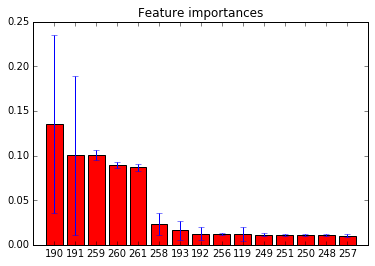

In [16]:
# feature importance plot (I don't know of a way of getting this from the gsCV_rf object from above, so I estimate again using the best parameters from the grid search)
rf = RandomForestClassifier(n_estimators=55, max_features=25)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(15), importances[indices[:15]], color="r", yerr=std[indices[:15]], align="center")
plt.xticks(range(15), indices[:15])
plt.xlim([-1, 15])
plt.show()

Feature numbers 260 and 261 are mean and median incomes by zip, respectively. Feature numbers 258 and 259 correspond to months November and December. Feature numbers 190 and 191 correspond to gender (I think...either that or a state). It is a difficult to tell what these correspond to and I need to find a good way of doing it (the problem is the encoding step which throws things off). 

## Preparing the holdout_.csv data

In [17]:
X_test = data_clean.data_clean('/Users/brenthowe/datascience/data sets/svg/holdout_.csv', train=False)

data_clean is executing


## Generating Predictions

In [19]:
# I think what I need to do is append the holdout to the original data, preprocess the data, and then separate the datasets

In [18]:
y_test_pred = rf.predict(X_test)

ValueError: Number of features of the model must  match the input. Model n_features is 262 and  input n_features is 222 

In [ ]:
holdout = pd.read_csv('/Users/brenthowe/datascience/data sets/svg/holdout_.csv')
holdout['predictions'] = y_test_pred

holdout.to_csv('/Users/brenthowe/datascience/data sets/svg/holdout_prediction.csv')

In [ ]:
# talk about how I can deal with missing values and the approach I take here

In [ ]:
# df.ix[df.fico_range == ran, 'fair'] = 1

# df_median['l'] = df_median['zip'].apply(lambda x: len(x))
# print df_median['l'].describe()
